`WUR Machine Learning Course - Assignment 1 - Version 2022`

# **Classification for Spatial Data**
Welcome to the second project of the MGI track of the course! In this exercise we will be performing a typical machine learning task for remote sensing: classifying a pair of satellite images into land cover classes on a per-pixel basis over the city of Zurich in Switzerland. As a word of advice, this project focuses more on understanding the pipeline than on coding it, and there are many different questions to test your understanding of the pipeline. **Therefore, we recommend to give short and to-the-point answers to the questions so that you have enough time for the entire project!** You can always go back and expand on a question once you've finished everything.

## **Background**
We will learn how to use a Python implementation of the Random Forest classifier. As the name suggests, a Random Forest is formed by random decision trees. Each tree is random in that the training samples are a random subset of the whole data and the descriptors (also called “features”) used in each split of the tree are randomly chosen. This makes each tree a quite weak classifier. However, if you average the results over many weak trees, then it becomes robust and works really well. This is the magic of ensemble learning! Actually, Random Forest is one of the most used and versatile classification algorithms. However, Random Forests are just one puzzle piece of a larger setup that is required for classification.

In detail, a traditional machine learning pipeline for classification as a couple of pre-defined steps:

1. Data Preparation
2. Feature Generation
3. Data Splitting
4. Model Parameter Tuning
5. Model Training
6. Feature Selection
7. Inference
8. Prediction Quality Control

In some cases you may also see predictor selection being performed (i.e. selecting the best type of model for a given task). Given that this is a relatively simple project, we do not do it here. This sequence of steps is valid for the vast majority of all classification tasks, but since we have remote sensing imagery as underlying data, we will alter a few of the steps to better address the spatial data. In the book (James, G., Witten, D., Hastie, T., Tibshirani, R., 2017: “An Introduction to Statistical Learning, with Applications in R.” Vol. 112, Springer, New York) the main chapters of interest are: 4.1 (we are doing classification) and 8.3 (using a tree-based model, a Random Forest).

## **Instructions**
We will be classifying a satellite image into a pre-defined set of land cover classes. “Land cover”, as the name suggests, describes the type of materials that are present at a specific spatial location on the earth. For example, grass or road are typical land cover classes, so is water (because it is visible in remote sensing images). Something like football field, however, is not, since it does not describe the type of material used.
The latter is called a land use class and is much harder to identify from above (but models exist to do so; ask us if you’re interested!). Most of the functions are given to you, but there are a couple of sections where you will have some code to fill in. If you are unsure about e.g. a function, we highly recommend that you make use of the various types of help that you can obtain:
* Check the documentation of the function
* Online help: Forums such as StackOverflow contain the answer to very many questions. Knowing how to search for these resources is a very valuable skill for a programmer.
* Ask a fellow student: Feel free to discuss the question with your fellow students to exchange ideas!
* If all else fails, let us know and we  will help you out.

**Finally, we have a few instructions for the notebook:**

* Sections marked with **``Action``** require you to undertake action or fill in some code to get it to run.
* Sections marked with **``Question``** require you to fill in an answer in the box below it.

With all that said, let's get started on the project!

# **Environment Set-Up**
We first need to install and import a couple of packages and functions for the classification pipeline.

In [ ]:
%pip install rasterio --quiet
%pip install matplotlib --quiet
%pip install scipy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 43.2 MB/s eta 0:00:00


In [ ]:
## General functions
import os
from pathlib import Path
from datetime import datetime

## Geo/Raster packages
import rasterio
from rasterio import plot as rio_plot

## Calculation functions
import random
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

## Plotting and visualization
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

# Turn off scientific notation in printing for ease of reading
np.set_printoptions(suppress=True)

We will also set seeds for the packages that we use.

In [ ]:
### Set global seeds ###
seed = 123
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

**``Question 1``**

``Why is it important to set a seed when working on machine learning models?``

**``Answer 1``**

For reproducability of the project. 

# **Importing Files to Colab**
**``Action 1``**

``Run the cell below and check if there is a new folder created on colab with the name `rs_data` containing several remote sensing images``



In [ ]:
! git clone https://gist.github.com/4369108d21efcba5743675add1c07def.git rs_data

Cloning into 'rs_data'...
remote: Enumerating objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 29
Unpacking objects: 100% (29/29), 7.16 MiB | 1.40 MiB/s, done.


# **1. Data Preparation**
In order to work with our raster images we need to import them, visualize them, and correct any mistakes or issues that we can see. We will use a combination of RasterIO and NumPy to do so.

### **Loading our raster images**
In this project we use two images, named ``img1`` and ``img2``. Image 1 is used during training and to calibrate the model. Image 2 is used to test the calibrated model.

In [ ]:
def open_raster(raster_path):
    ## Load image and make it readable as a NumPy matrix
    with rasterio.open(raster_path, 'r') as ds:
        return ds.read() 

# images: RGB
img1_rgb = open_raster('rs_data/image1_rgb.tif')
img1_nir = open_raster('rs_data/image1_nir.tif')
img1 = np.concatenate([img1_rgb, img1_nir], axis=0)

## images: NIR
img2_rgb = open_raster('rs_data/image2_rgb.tif')
img2_nir = open_raster('rs_data/image2_nir.tif')
img2 = np.concatenate([img2_rgb, img2_nir], axis=0)

### ground truths ###
## These DO NOT go into the image stack, since we evaluate
## the model predictions against these labelled maps
img1_gt = open_raster('rs_data/image1_groundTruth.tif')
img2_gt = open_raster('rs_data/image2_groundTruth.tif')

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### **Visualizing our raw data**
In order to understand what our images look like, we should plot them.
We first prepare the color ramp for the ground truth image raster.

In [ ]:
## These are the ground truth classes with their plot colors.
## Colors are given in # R-G-B-Alpha. Adjust them as you like.
## Note that not all classes are present in our small images
class_colors_dict = {
    'background':     [1,   1,   1,   1], # The background class is ignored during analyses
    'roads':          [0.5, 0.5, 0.5, 1],
    'buildings':      [0,   0,   0,   1],
    'trees':          [0,   0.5, 0,   1],
    'grass':          [0,   1,   0,   1],
    'bare soil':      [0.6, 0.3, 0,   1], # Not present
    'water':          [0,   0,   1,   1],
    'railways':       [1,   1,   0,   1], # Not present
    'swimming pools': [0,   0,   0.6, 1], # Not present
}
class_colors = [v for k,v in class_colors_dict.items()]
class_cm = np.array(class_colors)

## Get ground truth classes found in image 1
gt_values_in_img1 = np.unique(img1_gt)
img1_class_map = class_cm[gt_values_in_img1]
img1_cmap = ListedColormap(img1_class_map)

## Get ground truth classes found in image 2
gt_values_in_img2 = np.unique(img2_gt)
img2_class_map = class_cm[gt_values_in_img2]
img2_cmap = ListedColormap(img2_class_map)

We then plot ``img1`` next to the ground truth labels, which will be used for training, so that we can visualize our raster data to check if there are any issues.

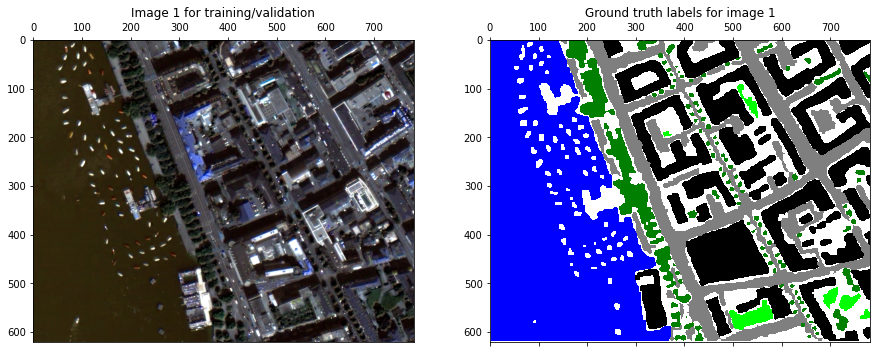

In [ ]:
## Plot the first three bands
fig, (ax_img1, ax_img1_gt) = plt.subplots(1, 2, figsize=(15, 15))
rio_plot.show(img1[:3], ax=ax_img1) ## Plot the image on the left
ax_img1.xaxis.set_ticks_position('top')
ax_img1.set_title("Image 1 for training/validation")

ax_img1_gt.matshow(img1_gt[0], cmap=img1_cmap) ## Plot the ground truth image on the right
ax_img1_gt.set_title("Ground truth labels for image 1")
plt.show(fig)

### **Band order corrections**

The image above is clearly in a false color arrangement. The water is brown instead of blue and the roofs are blue instead of red. As it turns out, the image bands are arranged in Blue-Green-Red-NIR order, instead of Red-Green-Blue-NIR. Let's fix this.

**``Action 2``**

``Define the correct band order on the first line below``

In [ ]:
## Fill in the band numbers so that the bands are R-G-B-NIR
corr_band_order = [2, 1, 0, 3]

img1_fixed = np.array([
                       img1[corr_band_order[0]],
                       img1[corr_band_order[1]],
                       img1[corr_band_order[2]],
                       img1[corr_band_order[3]],
                      ])

img2_fixed = np.array([
                       img2[corr_band_order[0]],
                       img2[corr_band_order[1]],
                       img2[corr_band_order[2]],
                       img2[corr_band_order[3]],
                      ])

Now let's visualize the fixed image to see if it's correct.

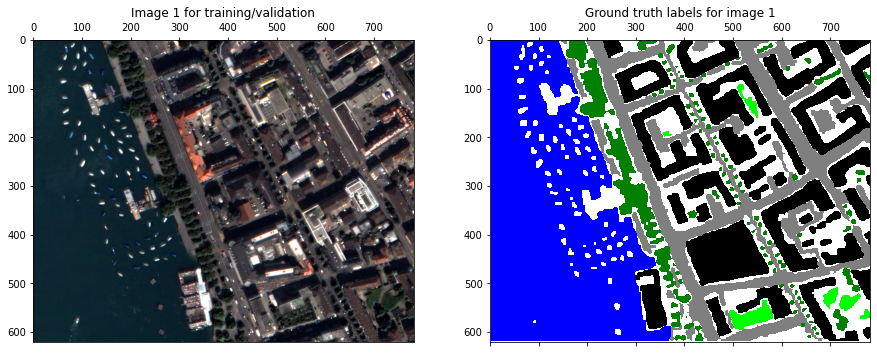

In [ ]:
## Plot one of the updated images
fig, (ax_img1_fixed, ax_img1_gt) = plt.subplots(1, 2, figsize=(15,15))
rio_plot.show(img1_fixed[:3], ax=ax_img1_fixed)
ax_img1_fixed.xaxis.set_ticks_position('top')
ax_img1_fixed.set_title("Image 1 for training/validation")

ax_img1_gt.matshow(img1_gt[0], cmap=img1_cmap)
ax_img1_gt.set_title("Ground truth labels for image 1")
plt.show(fig)

We have checked our images and made sure that they look as they should. With that done, we can move on to the next step, which is to produce more meaningful features for our classifier to learn from.

## **2. Feature Generation**
In this section we will generate a couple of useful features that will help the model to more accurately classify the land cover classes.

### **NDVI**
We will be calculating a new feature, based on the per-pixel spectral values. This is called the *“Normalised Difference Vegetation Index”* (NDVI) and is the best-known index in remote sensing. It is particularly suited to distinguish between different vegetation covers, and especially between vegetation
and the other classes. The formula is given as follows:

$NDVI = \frac{NIR - Red}{NIR + Red}$

**``Action 3``**

``Fill in the NDVI formula in the function below``

In [ ]:
def calculate_ndvi(red_band, nir_band):
    ## Calculates a new NDVI band from the red and the NIR band
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi

In [ ]:
## We add a very small constant to the NIR band to prevent division by zero
img1_ndvi = calculate_ndvi(img1_fixed[0], img1_fixed[3]+0.0000001)
img2_ndvi = calculate_ndvi(img2_fixed[0], img2_fixed[3]+0.0000001)

Let's see how it looks.

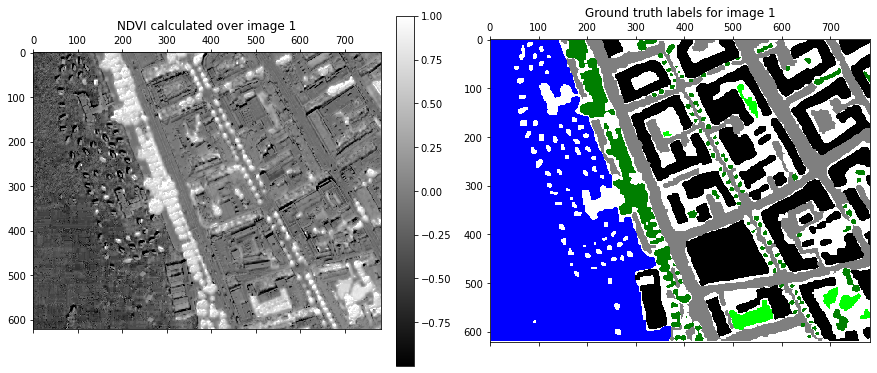

In [ ]:
## Plot the calculated NDVI raster
fig, (ax_ndvi, ax_img1_gt) = plt.subplots(1, 2, figsize=(15,15))

im = ax_ndvi.matshow(img1_ndvi, cmap=plt.get_cmap('gist_gray'))
plt.colorbar(im, fraction=0.046, pad=0.04, ax=ax_ndvi)
ax_ndvi.set_title("NDVI calculated over image 1")

ax_img1_gt.matshow(img1_gt[0], cmap=img1_cmap)
ax_img1_gt.set_title("Ground truth labels for image 1")
plt.show(fig)

**``Question 2``**

``Have a look at the plot above. Are there any classes that you can now better easier to tell apart by the naked eye?``

**``Answer 2``**

Yes we can classify pixels based on a higher or lower NDVI value: high NDVI relates to a vegetation class.

In [ ]:
## Lastly, we merge the NDVI values with the images
## img1_ndvi[:, None] is a Numpy trick to add an extra dimension for concatenation
img1_with_ndvi = np.concatenate([img1_fixed, img1_ndvi[None, :, :]], axis=0)
img2_with_ndvi = np.concatenate([img2_fixed, img2_ndvi[None, :, :]], axis=0)

### **Local statistics**
NDVI is a useful feature, but still acts only on a per-pixel basis. For such high resolutions, we need features calculated over neighbouring pixels as well. Research has proposed hundreds of spatial features over the time, such as “Histogram of Colours”, “Bag-of-Visual-Words”, “Grey-Level Co-occurrence Matrix”, and more. In this exercise we will use some simple local average values, calculated over the pixel and its eight neighbours. The neighbours included can be defined via the kernel size of the moving window. We set it to 3 as a default (i.e., we use a 3 × 3 moving window), but feel free to experiment with it (adjust parameter K to do so).

In [ ]:
## Define the two functions needed to extract local statistics
def calculate_raster_local_means(raster, K):
    ## Function which loops over an entire raster to get local statistics
    ## for each individual band
    raster_local_means = []
    for _, raster_band in enumerate(raster):
        band_local_means = calculate_band_local_mean(raster_band, K)
        band_local_means = band_local_means[None, :]
        raster_local_means.append(band_local_means)
    raster_local_means = np.concatenate(raster_local_means, axis=0)
    
    return raster_local_means

def calculate_band_local_mean(band_matrix, K):
    ## Function that calculates the mean of a raster band within
    ## the square window size K
    ## Adjusted from https://www.delftstack.com/howto/python/moving-average-python/
    N = K ** 2
    padded_band_matrix = np.pad(band_matrix, 1, constant_values = 0)
    local_means = convolve2d(padded_band_matrix, np.ones([K,K]), 'valid') / N
    
    return local_means

In [ ]:
## Call the function to extract local statistics
K = 3 # Kernel size for the local statistics sliding window

img1_local_means = calculate_raster_local_means(img1_with_ndvi, K)
img2_local_means = calculate_raster_local_means(img2_with_ndvi, K)

To improve the model accuracy, we have pre-calculated some additional features for you. In this step we will load and append them to both images (code provided). You don’t need to know the features for this project, but if you are curious, the features provided belong to the family of “mathematical morphology” operators and are: opening, closing, opening by reconstruction, closing by reconstruction; each with filter sizes 3 × 3 and 5 × 5 on the NIR band (so 8 features in total). Here’s some information on the subject: [Volpi, M., Tuia, D., Bovolo, F., Kanevski, M. and Bruzzone, L., 2013. Supervised change detection in VHR images using contextual information and support vector machines. International Journal of Applied Earth Observation and Geoinformation, 20, pp.77-85.](https://www.sciencedirect.com/science/article/abs/pii/S0303243411001565)

In [ ]:
## Load a bunch of extra features to help with the prediction
extra_features_img1 = [str(f) for f in Path('rs_data/').glob('**/im1*')]
img1_extra_features = [open_raster(f) for f in extra_features_img1]
img1_extra_features = np.concatenate(img1_extra_features)

extra_features_img2 = [str(f) for f in Path('rs_data/').glob('**/im2*')]
img2_extra_features = [open_raster(f) for f in extra_features_img2]
img2_extra_features = np.concatenate(img2_extra_features)

Lastly, we need to combine all of the features that we have computed and loaded into a new image array.

In [ ]:
## Merge all features
img1_with_features = np.concatenate([img1_with_ndvi, img1_local_means, img1_extra_features], axis=0)
img2_with_features = np.concatenate([img2_with_ndvi, img2_local_means, img2_extra_features], axis=0)

img1_with_features.shape

(18, 622, 782)

### **Normalisation**
We have now computed and loaded a large number of features which we can use to train our model. One final very important step in feature generation is data normalisation (also called standardisation). This brings all variables into similar numerical ranges and prevents variables with large values to dominate over the others (all variables are treated about equally). There are multiple
ways of standardising data; we will be using the so-called *“whitening”* technique. The formula is given as follows:

$X_{norm} = \frac{X - \mu(X)}{\sigma(X)}$

where $\mu(X)$ and $\sigma(X)$ are the column-wise average and standard deviations of our feature vector X, respectively. There is one catch to this: we cannot standardise the data for images 1 and 2 separately, because this would shift the two distributions incorrectly. Instead, we have to bring them to a common ground. A typical practice to this end is to normalise the test set data with the same average and standard deviation values as the training set.

Below we have given the formula to loop over the raster to normalize each band. However, the normalization step itself is left out for both rasters

**``Action 4``**

``Fill in the normalization formula for both images. Remember that we need to use the summary statistics of image 1 to normalize image 2!``

In [ ]:
def normalize_images(img1, img2):
    ## Function that normalizes the image by whitening it.
    ## We use the summary statistics of image 1 both for
    ## image 1 and 2 so that their distributions allign.
    img1_normalized = []
    img2_normalized = []

    def normalization(x, mean, std):
        return (x - mean)/ std

    for band_num, img1_band_matrix in enumerate(img1):
        # Calculate the summary statistics for the given band number for image 1
        img1_band_mean = np.mean(img1_band_matrix)
        img1_band_var = np.var(img1_band_matrix)
        img1_std = np.sqrt(img1_band_var)
        
        # Normalize image 1
        ''' FIL IN THE NORMALIZATION FUNCTION FOR THE BAND MATRIX OF IMAGE 1 HERE '''
  
        normalized_img1_band = normalization(img1_band_matrix, img1_band_mean, img1_std)

        # Normalize image 2 using image 1 summary statistics
        img2_band_matrix = img2[band_num]
        ''' FIL IN THE NORMALIZATION FUNCTION FOR THE BAND MATRIX OF IMAGE 2 HERE '''
        normalized_img2_band = normalization(img2_band_matrix, img1_band_mean, img1_std)

        # Append bands into a temporary list to later re-create the raster
        normalized_img1_band = normalized_img1_band[None, :]
        img1_normalized.append(normalized_img1_band)
        normalized_img2_band = normalized_img2_band[None, :]
        img2_normalized.append(normalized_img2_band)
    
    img1_normalized = np.concatenate(img1_normalized, )  
    img2_normalized = np.concatenate(img2_normalized)  
    
    return img1_normalized, img2_normalized

In [ ]:
img1_normalized, img2_normalized = normalize_images(img1_with_features, img2_with_features)
## If this raises an asseration error, you've not filled in the right variable in the function!
assert len(img1_normalized.shape) == 3

## **3. Data splitting**
In this part of the pipeline we subdivide the images in a training, validation, and test set. We refer to this process as "*data splitting*", since we "*split*" the dataset into disjoint bins. For training/validation we split our data vertically. We use the top 70% of our image for training, and the bottom 30% for validation.

In [ ]:
## Set-up the matrix for training
training_frac = 0.7 # 70% of pixels in img1 for training, 30% for validation
fraction_index = round(training_frac * img1_normalized.shape[1]) # Split along vertical axis

## Make the training/validation splits by splitting the matrix vertically (row-wise)
## The first dimension is the band (feature), the second the row, and the third the column of the image
training_matrix = img1_normalized[:, :fraction_index, :]
training_matrix_labels = img1_gt[:, :fraction_index, :]

validation_matrix = img1_normalized[:, fraction_index:, :]
validation_matrix_labels = img1_gt[0, fraction_index:, :] # The valdidation matrix has only GT labels as band

Let's visualize our splits. In the plot below, the right image shows training pixels in blue, and validation pixels in red.




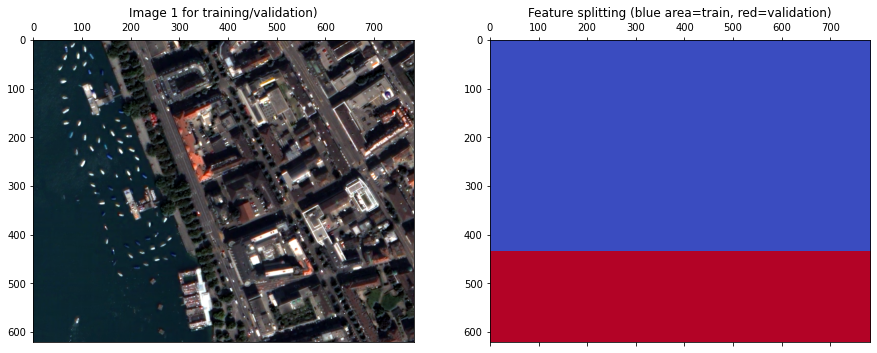

In [ ]:
## Make a simple matrix where validation cells are marked with a 1.
## 
splits_fig = np.zeros_like(img1_gt)
## Fill the validation pixels with the value 1.
splits_fig[:, fraction_index:, :] = 1

## Plot the splits used for training
fig, (ax_img1, ax_splits) = plt.subplots(1, 2, figsize=(15, 15))
rio_plot.show(img1_fixed[:3], ax=ax_img1)
ax_img1.set_title("Image 1 for training/validation)")
ax_img1.xaxis.set_ticks_position('top')

ax_splits.matshow(splits_fig[0], cmap=plt.get_cmap('coolwarm'))
ax_splits.set_title("Feature splitting (blue area=train, red=validation)")
plt.show(fig)

**``Question 3a``**

``Why do we spatially divide our training and validation data within the same image?``

**``Answer 3a``**

So that we can test the performance of the model with an independent dataset. Also, all classes are represented in both the training and validation dataset when divided horizontally.

**``Question 3b``**

``What would happen if we pick random pixels instead of spatially stratified pixels?``

**``Answer 3b``**

We think that picking random pixels, than there would be a chance that not every class is represented in both the validation and training dataset.

**``Question 3c``**

``Why don't we include image 2 during training, and why is it unnecessary to spatially stratify image 2?``

**``Answer 3c``**

Because we want to keep an independent dataset to later test the model on.

### **Data clean-up**
The data needs some minor adjustments before it can be used for the random forest model. We need to flatten the spatial dimensions, and we need to remove the background pixels from the analyses, since this class is too difficult for the model to predict. No action is required in this step.

In [ ]:
## Flatten the splits so that they're 1-dimensional
train_pixels = training_matrix.reshape(training_matrix.shape[0], training_matrix.shape[1] * training_matrix.shape[2])
train_labels = training_matrix_labels[0].reshape(training_matrix.shape[1] * training_matrix.shape[2])

val_pixels = validation_matrix.reshape(validation_matrix.shape[0], validation_matrix.shape[1] * validation_matrix.shape[2])
val_labels = validation_matrix_labels.reshape(validation_matrix_labels.shape[0] * validation_matrix_labels.shape[1])

## Rearrange the training array so that the dimension axis is last
train_pixels = train_pixels.transpose()
val_pixels = val_pixels.transpose()

## Remove background pixels from the arrays
train_pixels = train_pixels[train_labels != 0, :]
train_labels = train_labels[train_labels != 0]
val_pixels = val_pixels[val_labels != 0, :]
val_labels = val_labels[val_labels != 0]

## **4. Model parameter tuning**
After extracting features and preparing the data, we can start to tune our model. We use a parameter tuning process known as *parameter searching*, where we define parameter combinations with which we can tune the model. For our random forest model, we only need to tune the number of trees and the number of samples needed to form a split in each tree. We use just 10% of the training pixels to limit the time needed to train the model. We randomly sample these from the training array.

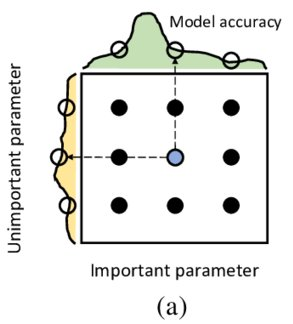

(A visual example of grid search, where parameter searching occurs in a grid with regular intervals. Adapted from [Pilario, Cao, and Shafiee](https://www.researchgate.net/publication/341691661_A_Kernel_Design_Approach_to_Improve_Kernel_Subspace_Identification))

In [ ]:
## Set grid search parameters
## typical number of trees can go up to 1000, depending on the dataset size and model complexity
## For a simple, small image, we don't need to bother going over 100
n_trees_range = [1,10,25,50,100]
min_samples_range = [2,5,10,25,50] # Minimum number of samples needed to form a leaf

## prepare matrix for storing model accuracy reached on the validation set per parameter combination
acc_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

## we also measure the time it takes to train models
time_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

Now it's time to search our parameter combinations. We track the overall accuracy on the validation set achieved by a model trained on each parameter combination, as well as the time needed to train each model.

In [ ]:
## Temporarily merge the matrices so that the sampling picks the same elements in both arrays
subset_matrix = np.concatenate([train_pixels, train_labels[:, None]], axis=1)

## Randomly select pixels from the original training matrix
paramsearch_frac = 0.1
n_pixels = round(paramsearch_frac * train_pixels.shape[0])
subset_indices = np.random.choice(subset_matrix.shape[0], n_pixels, replace=False)
subset = subset_matrix[subset_indices, :]

## Un-merge the arrays, which have now been sampled from
paramsearch_train_samples = subset[:,:-1]
paramsearch_train_labels = subset[:,-1]

We track the accuracy for each variable combination, as well as the time it takes to train the model.

In [ ]:
## Perform the parameter searching and keep track of performance/time
## We loop over all possible combinations of both parameters
for n_trees_index, n_trees in enumerate(n_trees_range):
    for min_leaves_index, min_samples in enumerate(min_samples_range):
        print(f"N trees: {n_trees}, Min. samples samples per leaf: {min_samples}")
        
        ## Initialize the random forest classifier
        model = RandomForestClassifier(n_estimators=n_trees, min_samples_split=min_samples)
        
        ## Fit the classifier to the training data/labels
        start = datetime.now()
        model.fit(paramsearch_train_samples, paramsearch_train_labels)
        end = datetime.now()
        time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

        ## Use the model to predict all of the validation pixels
        predictions = model.predict(val_pixels)

        ## Calculate the accuracy of the predicted labels vs the ground truth labels
        acc = accuracy_score(predictions, val_labels)

        ## Store accuracies and time taken for this parameter combination
        acc_paramsearch[n_trees_index, min_leaves_index] = round(acc, 3)
        time_paramsearch[n_trees_index, min_leaves_index] = round(time_taken, 3)     

N trees: 1, Min. samples samples per leaf: 2
N trees: 1, Min. samples samples per leaf: 5
N trees: 1, Min. samples samples per leaf: 10
N trees: 1, Min. samples samples per leaf: 25
N trees: 1, Min. samples samples per leaf: 50
N trees: 10, Min. samples samples per leaf: 2
N trees: 10, Min. samples samples per leaf: 5
N trees: 10, Min. samples samples per leaf: 10
N trees: 10, Min. samples samples per leaf: 25
N trees: 10, Min. samples samples per leaf: 50
N trees: 25, Min. samples samples per leaf: 2
N trees: 25, Min. samples samples per leaf: 5
N trees: 25, Min. samples samples per leaf: 10
N trees: 25, Min. samples samples per leaf: 25
N trees: 25, Min. samples samples per leaf: 50
N trees: 50, Min. samples samples per leaf: 2
N trees: 50, Min. samples samples per leaf: 5
N trees: 50, Min. samples samples per leaf: 10
N trees: 50, Min. samples samples per leaf: 25
N trees: 50, Min. samples samples per leaf: 50
N trees: 100, Min. samples samples per leaf: 2
N trees: 100, Min. samples

Let's plot the grid to see the effect of the parameter tuning.

<ipython-input-27-4591b4cf32ef>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_acc.set_xticklabels(n_trees_labels)
<ipython-input-27-4591b4cf32ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_acc.set_yticklabels(min_leaves_labels)
<ipython-input-27-4591b4cf32ef>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_time.set_xticklabels(n_trees_labels)
<ipython-input-27-4591b4cf32ef>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_time.set_yticklabels(min_leaves_labels)


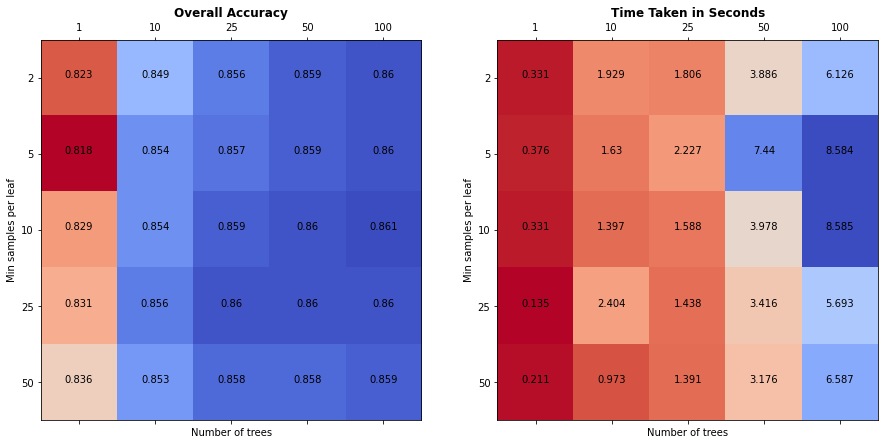

In [ ]:
## Dirty work-around for first label not showing when plotting
n_trees_labels = [0] + n_trees_range
min_leaves_labels = [0] + min_samples_range 

fig, (ax_acc, ax_time) = plt.subplots(1, 2, figsize=(15,15))

## Plot accuracy
ax_acc.set_title("Overall Accuracy", weight='bold')
ax_acc.set(xlabel='Number of trees', ylabel='Min samples per split')
ax_acc.set_xticklabels(n_trees_labels)
ax_acc.set_yticklabels(min_leaves_labels)
ax_acc.matshow(acc_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot time taken
ax_time.set_title("Time Taken in Seconds", weight='bold')
ax_time.set(xlabel='Number of trees', ylabel='Min samples per split')
ax_time.set_xticklabels(n_trees_labels)
ax_time.set_yticklabels(min_leaves_labels)
ax_time.matshow(time_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Add text to accuracy plot
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_acc.text(t_i, l_i, s=acc_paramsearch[t_i, l_i], ha='center')

## Add text to time plot
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_time.text(t_i, l_i, s=time_paramsearch[t_i, l_i], ha='center')

**``Question 4a``**

``Looking at the left plot of the grid above, is the model accuracy for each parameter pair as you would expect it? Why/why not?``

**``Answer 4a``**

The overall accuracy grid shows low accuracy for a model with few trees and samples per leaf. A small number of samples per leaf results in a more flexible model with a high variance, which results in overfitting and higher test error. Likewise, a small number of trees will result in a model that varies a lot depending on the input data, thus overfitting. 

**``Question 4b``**

``What about the time taken for each parameter? Is it according to your expectations? Why/why not?``

**``Answer 4b``**

As expected, it takes more time to run a random forest model with an increasing number of trees and samples. There are some slight difference potentially due to the randomness of the model fit. 

**``Question 4c``**

``Given the above, which combination of parameters do you pick for the final model, and why do you pick that combination?``

**``Answer 4c``**

We take a model with 25 trees and 25 samples per leaf, as it has one of the highest accuracies (0.86). It is also the fastest of the high scoring combinations. 

## **5. Model Training**

Now that we know which parameter combinations are good to use, we can train a model on all of the training pixels.

**``Action 5``**

``Finish the line which calls the random forest classifier with your chosen parameters and train the model.``

In [ ]:
## Fill in your choice of parameters and set up the random forest classifier
num_trees = 25
min_num_leaves = 25

model = RandomForestClassifier(n_estimators = num_trees, min_samples_split = min_num_leaves)

## Run the classifier on the entire training set
train_start = datetime.now()
model.fit(train_pixels, train_labels)
train_end = datetime.now()
time_taken = float(f"{(train_end - train_start).seconds}.{round((train_end - train_start).microseconds, 2)}")

## Check training accuracy
train_preds = model.predict(train_pixels)
train_acc = accuracy_score(train_preds, train_labels)

## Run the model on the validation pixels
val_preds = model.predict(val_pixels)
val_acc = accuracy_score(val_preds, val_labels)

print(f'Training accuracy:   {train_acc:.4f}')
print(f'Validation accuracy: {val_acc:.4f}')
print(f'Training time:       {time_taken:.3f} seconds')

Training accuracy:   0.9647
Validation accuracy: 0.8597
Training time:       23.244 seconds


## **6. Feature Selection**
In the previous steps we have created a few features (NDVI, local statistics,
etc.), all there to facilitate the task of the classifier: to separate groups of
pixels according to their high-level semantic land cover classes. However, not every new feature is automatically useful. For example, if the number of data points is limited, one can quickly get the so-called curse of dimensionality (page 242 in the book). Even worse, some features may actually be harmful, in the way that including them into the model eventually degrades the final model performance! This notion of variable worthiness is called “Predictor Importance” or “Variable Importance” (page 319 in the book). Luckily, Random Forests have some useful properties that help us evaluating whether a feature (or predictor) is actually of use or not. In this exercise we will be using the Random Forests’ ability to assess predictor importance to select which variables to keep. Remember: in this case we treat each variable equally, meaning that it does not matter if we e.g. remove the local average for the red band, but keep the local averages for the others. Our main goal is to maximise the model performance on a given set of pixels.

In [ ]:
## The GINI coefficient is calculated by default when training a model
features_gini = model.feature_importances_

## We fit a second model to derive the entropy of each variable
entropy_model = RandomForestClassifier(n_estimators=num_trees, min_samples_split=min_num_leaves, criterion='entropy')
entropy_model.fit(train_pixels, train_labels)
features_entropy = entropy_model.feature_importances_

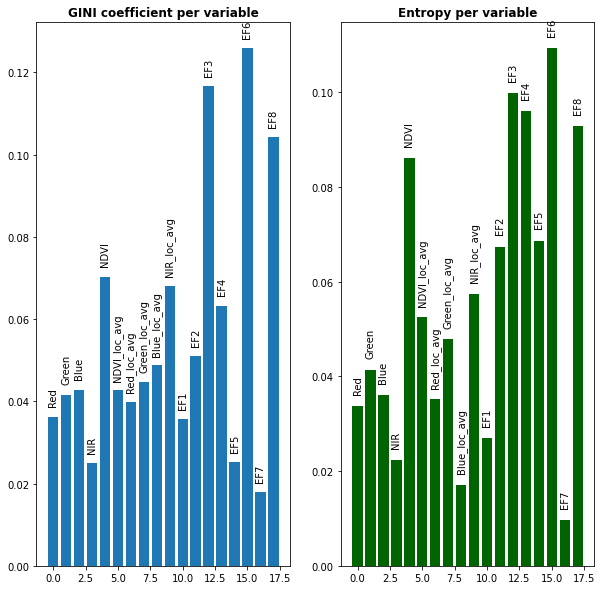

In [ ]:
## Give each feature band a name
feature_names = [
                 'Red',
                 'Green',
                 'Blue',
                 'NIR',
                 'NDVI',
                 'NDVI_loc_avg',
                 'Red_loc_avg',
                 'Green_loc_avg',
                 'Blue_loc_avg',
                 'NIR_loc_avg',
                 'EF1',
                 'EF2',
                 'EF3',
                 'EF4',
                 'EF5',
                 'EF6',
                 'EF7',
                 'EF8'
]

## Make bar plots
x_axis = range(len(features_gini))
fig, (ax_gini, ax_entropy) = plt.subplots(1, 2, figsize=(10,10))
ax_gini.bar(x_axis, features_gini)
ax_gini.set_title("GINI coefficient per variable", weight='bold')
ax_entropy.bar(x_axis, features_entropy, color='darkgreen')
ax_entropy.set_title("Entropy per variable", weight='bold')

## Add labels to the bars
for index, label in enumerate(feature_names):
    ax_gini.text(index, y=features_gini[index]+0.003, s=label, ha='center', rotation=90)
for index, label in enumerate(feature_names):
    ax_entropy.text(index, y=features_entropy[index]+0.003, s=label, ha='center', rotation=90)   

**``Question 5a``**

``What is plotted in the bar plots above? What does each metric tell us about the variables? (Hint: check page 344 of the book)``

**``Answer 5a``**

The bar plots illustrate the Gini index and the entropy of each variable in the model to determine which predictors are more important in classifying the pixels. For both metrics, a higher score indicates more impurity, less separability between classes. 

**``Question 5b``**

``Based on the plots above, which variables would you leave out of the model, and why would you leave them out?``

**``Answer 5b``**

The variables NIR_loc_avg, EF2, EF4, and EF5 would be left out of the model as they have the highest Gini coefficient and entropy out of all the variables. 

**``Action 6``**

``Determine which variables to remove in the final model by defining a list below``

In [ ]:
## Determine which variables to remove by using their band names
features_to_remove = ['NIR_loc_avg', 'EF2', 'EF4', 'EF5']

features_to_remove = [f.lower() for f in features_to_remove]
features_to_keep = [i for i, k in enumerate(feature_names) if not k.lower() in features_to_remove]

## Update all feature selections
selected_train_pixels = train_pixels[:, features_to_keep]
selected_val_pixels = val_pixels[:, features_to_keep]

We can now re-train our final model with the new sub-selection of variables.

**``Action 7``**

``Edit the line below to initialize the random forest model``

In [ ]:
## Initialize the final model that we will train
final_model = RandomForestClassifier(n_estimators = num_trees, min_samples_split = min_num_leaves)

## Train the model on the training dataset
selected_train_start = datetime.now()
final_model.fit(selected_train_pixels, train_labels)
selected_train_end = datetime.now()
selected_time_taken = float(f"{(selected_train_end - selected_train_start).seconds}.{round((selected_train_end - selected_train_start).microseconds, 2)}")

## Check the updated model's accuracy on the training set
selected_train_preds = final_model.predict(selected_train_pixels)
seleted_train_acc = accuracy_score(selected_train_preds, train_labels)

## Check the accuracy on the validation set
selected_val_preds = final_model.predict(selected_val_pixels)
selected_val_acc = accuracy_score(selected_val_preds, val_labels)

print(f'Training accuracy:   {seleted_train_acc:.4f}')
print(f'Validation accuracy: {selected_val_acc:.4f}')
print(f'Training time:       {selected_time_taken:.3f} seconds')

Training accuracy:   0.9563
Validation accuracy: 0.8585
Training time:       19.626 seconds


**``Question 6``**

``Most likely, the validation accuracy of your new model went down compared to the model using all of the variables. Why then is it still important to perform feature selection, even if it leads to slightly lower accuracy values?``

**``Answer 6``**

Feature selection results in a simpler model and thus faster processing time, which is essential when handling larger images and datasets. 


## **7. Inference**
Now that we have selected our useful variables, we can move on to performing *inference*, which is the process of running a trained model on new, unseen data.

**``Question 7``**

``Which part of the data will you use for this inference run?``

**``Answer 7``**

Image 2 used to infer the model as it was not included to train the model. 

**``Action 8``**

``Fill in the variable name of the raster that you intend to use for testing``

In [ ]:
## Select the image to use during testing
test_raster = img2_normalized ## Hint: It should be normalized
test_raster = test_raster[features_to_keep,:, :]

## Model only supports 2-dim input, so we need to perform the model row-wise
## We make a matrix to store the prediction results in
test_results_matrix = np.ones_like(img2_gt)

## Apply the model on every row of the input image.
for xdim_index in range(img2_normalized.shape[1]):
    test_row = test_raster[:,xdim_index,:]
    test_row_preds = final_model.predict(test_row.transpose())
    test_results_matrix[:, xdim_index,:] = test_row_preds

## **8. Prediction Quality Control**
Now that we have run the model on the test set, we can explore how well it performs. We do so both by assessing the visual results of the model, as well as through statistics. Let's first see how the spatial predictions of the model look compared to the ground truth data.

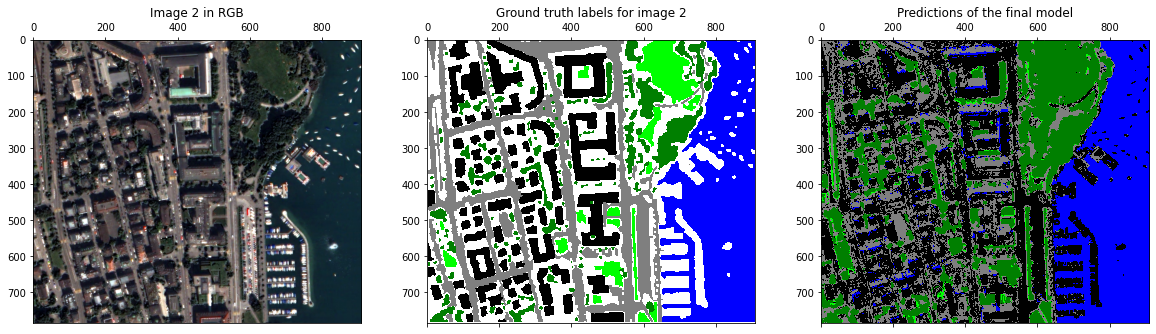

In [ ]:
## Make a color map for the predictions
values_in_preds = np.unique(test_results_matrix)
preds_class_map = class_cm[values_in_preds]
preds_cmap = ListedColormap(preds_class_map)

## Create plots for the images
fig, (ax_img2, ax_img2_gt, ax_img2_pred) = plt.subplots(1, 3, figsize=(20,20))
rio_plot.show(img2_fixed[:3], ax=ax_img2)
ax_img2.xaxis.set_ticks_position('top')
ax_img2.set_title("Image 2 in RGB")

ax_img2_gt.matshow(img2_gt[0], cmap=img2_cmap)
ax_img2_gt.set_title("Ground truth labels for image 2")

ax_img2_pred.matshow(test_results_matrix[0], cmap=preds_cmap)
ax_img2_pred.set_title("Predictions of the final model")
plt.show(fig)

**``Question 8a``**

``Are you satisfied with the prediction results? Why, or why not?``

**``Answer 8a``**

No. The main issue is that the predicted image classified grass areas as trees. It overestimates trees in general and misclassifies certain shade areas as water. Lastly, the marina and the roads are classified as buildings.

**``Question 8b``**

``Do you see any systematic errors in the predictions? (random blunders, systematic confusions, etc)? Which ones and where?``

**``Answer 8b``**

See above

**``Question 8c``**

``How do you think these can be avoided?``

**``Answer 8c``**

Better ground truthing with less no data pixels (just get on the boats). Adding a new class for boats. Adding a new predictor to differentiate better between vegetation or infrastructure types. 

Let's try something fun . Usually this sort of information isn't known for new, unseen data, but here we know which pixels the model should ignore, because they're part of the background class (the white pixels). Let's correct the plot for the background class so that we can compare the pixels that the model should predict correctly.

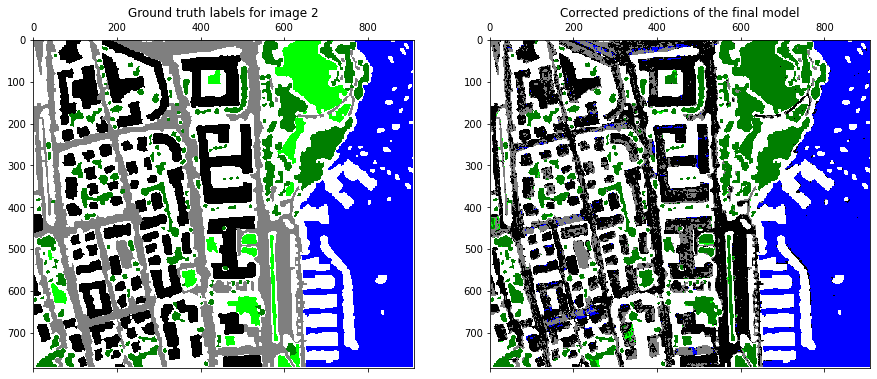

In [ ]:
## Set pixels in the prediction raster which have a 0 in the ground truth at the same index to 0
corrected_predictions = test_results_matrix.copy()
corrected_predictions[img2_gt == 0] = 0

## Update the color map
values_in_preds = np.unique(corrected_predictions)
preds_class_map = class_cm[values_in_preds]
preds_cmap = ListedColormap(preds_class_map)

## Plot the corrected label maps side by side
fig, (ax_img2_gt, ax_img2_pred) = plt.subplots(1, 2, figsize=(15,15))
ax_img2_gt.matshow(img2_gt[0], cmap=img2_cmap)
ax_img2_gt.set_title("Ground truth labels for image 2")

ax_img2_pred.matshow(corrected_predictions[0], cmap=preds_cmap)
ax_img2_pred.set_title("Corrected predictions of the final model")
plt.show(fig)





For this question, look at the differences between the non-white pixels of both label maps.

**``Question 9``**

``Based on the corrected pixel map above, make an educated guess on what the overall accuracy will be. Mention the number and briefly explain what it is based on.``

**``Answer 9``**

The overall accuracy is probably around 60-70% as the model correctly classified the water, tree, and buildings classes and incorrectly classified the grass and roads. This guestimate is based on the correct pixel proportion in the image. 

Now that you've made your prediction in ``question 10``, let's see what the overall accuracy is like on the test set when we ignore the background pixels.

In [ ]:
## Compute accuracy over the test set without considering the background class
gt_zeros_removed = img2_gt[img2_gt != 0]
preds_zeros_removed = test_results_matrix[img2_gt != 0]

test_acc = accuracy_score(preds_zeros_removed.ravel(), gt_zeros_removed.ravel())
print(f'Test overall accuracy:   {test_acc:.4f}')

Test overall accuracy:   0.6758


**``Question 10a``**

``Are you surprised by the overall accuracy? Why/why not?``

**``Answer 10a``**

Nope (very pleased actually with our guessing skills). This just confirms our expectations. 

**``Question 10b``**

``Do you think that the achieved overall accuracy reflects the quality of the final model? (Again, take into account that white background pixels have been manually set in the plot above)``

**``Answer 10b``**

No because the manual addition of white background pixels results in an overestimated overall accuracy. Additionally, it would be more informative to create a confusion matrix to calculate the user and producer accuracies (or precision and recall). This would also provide us some indications of how to improve our dataset/model.  

We can begin to explain our model in more detail by making a confusion matrix so that we can look at which classes are often predicted incorrectly.

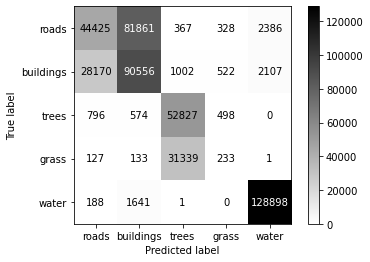

In [ ]:
## Get matrix labels from the predictions in the ground truth raster
labels = [k for i, k in enumerate(class_colors_dict) if i in set(gt_zeros_removed)]

## Make confusion matrix
conf_matrix = confusion_matrix(gt_zeros_removed.ravel(), preds_zeros_removed.ravel())
conf_matrix_viewer = ConfusionMatrixDisplay(conf_matrix, display_labels=labels)
conf_matrix_viewer.plot(cmap=plt.get_cmap('binary'))

**``Question 11``**

``Which classes are confused with one another most often? Can you reason why these classes are confused most often?``

**``Answer 11``**

Grass is often confused with trees (but not the other way around). More importantly, the roads and buildings get confused with each other often. These infrastructure classes are confused with each other as they have similar construction material, therefore similar spectral signatures and shapes compared to other classes. Similarly, grass is misclassified as trees due to similar reflectance behaviors throughout the year and the diversity in plant types. 

As you can tell, the overall accuracy of a model doesn't always accurately reflect the true quality of a model. Let's therefore consider alternative statistical tests which give us a more fair representation. For this, we will assess the *precision* and *recall* scores of the predictions for each class individually.

**``Question 12``**

``In your own words, describe what the precision and recall scores represent, and how they're calculated. You can use internet resources or literature to help explain these concepts.``

**``Answer 12``**

Precision is the percentage of predicted positives that is correct. Meanwhile, the recall is the percentage of positive cases prodicted correctly. Thus, recall measures the ability of the model to find all positive cases while the precision measures its ability to avoid false positives.

In [ ]:
## Calculate precision and recall scores for each class individually
test_precisions = precision_score(preds_zeros_removed.ravel(), gt_zeros_removed.ravel(), average=None)
test_recalls = recall_score(preds_zeros_removed.ravel(), gt_zeros_removed.ravel(), average=None)
'''
## Print these for each class separately
print("Test set precision scores per class")
for i, label in enumerate(labels):
    print(f"{label}: {test_precisions[i]:.4f}")
print("\n")
print("Test set recall scores per class")
for i, label in enumerate(labels):
    print(f"{label}: {test_recalls[i]:.4f}") 
'''
tab_scores = pd.DataFrame(data = [test_recalls, test_precisions], index = ['recall', 'precision'], columns = labels)
tab_scores

,roads,buildings,trees,grass,water
recall,0.602732,0.518159,0.617600,0.147375,0.966310
precision,0.343403,0.740097,0.965847,0.007319,0.986001



**``Question 13a``**

``When you compare these precision/recall scores with the overall accuracy, how has your perception of the performance of the model changed?``

**``Answer 13a``**

As expected, the roads and grass classes have the lowest precision scores, these classes .... 

**``Question 13b``**

``Now that you've seen all of the statistical results, which label predictions do you think are primarily responsible for the high overall accuracy?``

**``Answer 13b``**
We observe that the high recall and precision of the large water class, 0.966 and 0.986, respectively, lead to a skewed overall accuracy. This high accuracy is not representative of the real model performance. 

## Finishing Up
And that's a wrap on this project. Hopefully you learned something useful about classification pipelines for remote sensing data, random forest classifiers, and finally the importance of being critical of the metrics and visualizations that you use to assess your model quality. Good luck with the remainder of the course!